# Task

Null hypothesis is that change in the design of form for the test group would result in no change in the conversion rate.

# Data loading and investigation.

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm

Read data from excel sheet to dataframe.

In [110]:
frame = pd.read_excel('DatasetTask1SolidDataAnalyst.xlsx', sheet_name='Sheet2')

In [111]:
frame.head()

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_os_version,config_resolution,idvisit,platform_v4
0,Other,CHROME MOBILE,SMARTPHONE,1,old,AND,7,360x640,4801472,MOB
1,Other,Other,NaN,1,old,AND,4.3,1440x1440,4790389,MOB
2,SAMSUNG,CHROME MOBILE,SMARTPHONE,1,new,AND,7,360x640,5272442,MOB
3,APPLE,MOBILE SAFARI,SMARTPHONE,1,new,IOS,11.3,414x736,5030185,MOB
4,Other,CHROME MOBILE,SMARTPHONE,1,old,AND,7,360x640,3857978,MOB


Check if there null values in A/B column.

In [112]:
frame['A/B'].isnull().values.any()

False

In [113]:
N = frame.shape[0]
print(N)
visits = frame.idvisit.nunique()
print(visits)

26585
26585


There is only unique id in data.

Check probability of getting new page.

In [114]:
New_p = frame[frame['A/B']=='new'].shape[0] /  N
print("The probability that an individual received the new page is {0:.2%}".format(New_p))

The probability that an individual received the new page is 58.04%


# Calculate sample size.

Let's calculate sample size needed to find difference in data.

In [115]:
def get_sample_size(p=0.5):
    z = 1.96 #z-score for confidence level (95% for 1.95)
    e = 0.05 #margin of error

    return (z * z) * p * (1 - p) / (e * e)

Calculate conversion for control group.

In [116]:
N_A = frame[frame['A/B']=='old'].shape[0]
N_B = frame[frame['A/B']=='new'].shape[0]
p = float(frame[frame['Conversion']==1].shape[0])/frame.shape[0]
print("Conversion for control group is {0:.2%}".format(p))

Conversion for control group is 12.09%


In [117]:
print("Minimal sample size needed is {0}".format(int(get_sample_size(p)+1)))

Minimal sample size needed is 164


Find conversion for each group.

In [118]:
ab_summary = frame.pivot_table(values='Conversion', index='A/B', aggfunc=np.sum)
ab_summary['total'] = frame.pivot_table(values='Conversion', index='A/B', aggfunc=lambda x: len(x))
ab_summary['rate'] = frame.pivot_table(values='Conversion', index='A/B')

In [119]:
ab_summary

,Conversion,total,rate
A/B,,,
new,1865,15429,0.120876
old,1350,11156,0.121011


In [120]:
# Save probability to variables
p_A = ab_summary.rate.old
p_B = ab_summary.rate.new

In [121]:
# Calculate converted count for each group
A_converted = frame[(frame['A/B']=='old')&(frame['Conversion']==1)].shape[0]
B_converted = frame[(frame['A/B']=='new')&(frame['Conversion']==1)].shape[0]

# Visualize data

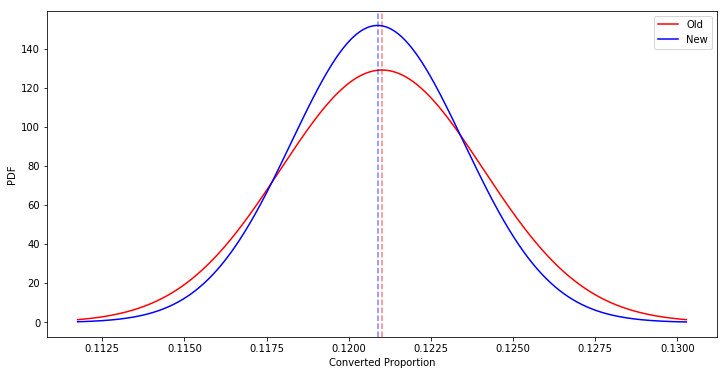

In [122]:
# standard error of the mean for both groups
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(N_A)
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(N_B)
# plot the null and alternate hypothesis
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(p_A-3*SE_A, p_A+3*SE_A, N_A)
xB = np.linspace(p_A-3*SE_A, p_A+3*SE_A, N_B)
yA = scs.norm(p_A, SE_A).pdf(xA)
ax.plot(xA, yA, c='red', label='Old')
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')
yB = scs.norm(p_B, SE_B).pdf(xB)
ax.plot(xB, yB, c='blue', label='New')
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')

plt.xlabel('Converted Proportion')
plt.ylabel('PDF')
plt.legend()
plt.show()

The dashed lines represent the mean conversion rate for each group. The distance between the red dashed line and the blue dashed line is equal to mean difference between the control and test group. 

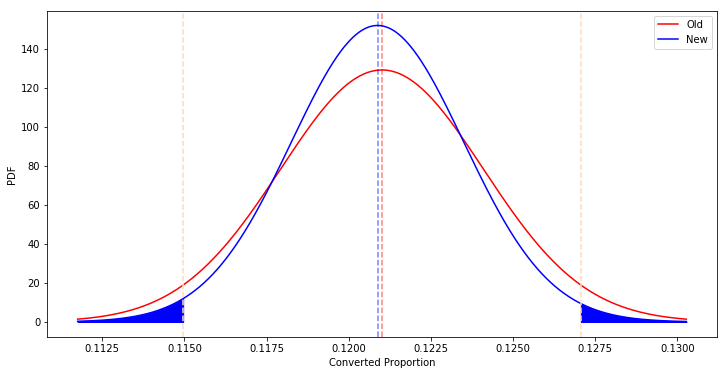

In [123]:
#Calculate 95% confidential interval for old version
a, b = proportion_confint(A_converted, N_A, alpha=0.05, method='normal')


# standard error of the mean for both groups
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(N_A)
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(N_B)
# plot the null and alternate hypothesis
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(p_A-3*SE_A, p_A+3*SE_A, N_A)
xB = np.linspace(p_A-3*SE_A, p_A+3*SE_A, N_B)
yA = scs.norm(p_A, SE_A).pdf(xA)
ax.plot(xA, yA, c='red', label='Old')
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')
yB = scs.norm(p_B, SE_B).pdf(xB)
ax.plot(xB, yB, c='blue', label='New')
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')

ax.axvline(x=a, c='peachpuff', alpha=1, linestyle='--')
ax.axvline(x=b, c='peachpuff', alpha=1, linestyle='--')

x_list = [item for item in xB if item > b]
y_list = yB[-len(x_list):]
ax.fill_between(x_list, 0, y_list, color='blue')

x_list = [item for item in xB if item < a]
y_list = yB[:len(x_list)]
ax.fill_between(x_list, 0, y_list, color='blue')

plt.xlabel('Converted Proportion')
plt.ylabel('PDF')
plt.legend()
plt.show()

The blue shaded area represents the statistical power, and the calculated value for power is also displayed on the plot. The red dashed lines in the plot above represent the confidence interval (95%) for the null hypothesis. Statistical power is calculated by finding the area under the alternative hypothesis distribution and outside of the confidence interval of the null hypothesis.

# Hypothesis testing 

In [124]:
#Import regression model library
import statsmodels.api as sm

Now use stats.proportions_ztest to compute your test statistic and p-value.

In [125]:
z_score, p_value = sm.stats.proportions_ztest(np.array([A_converted,B_converted]),np.array([N_A,N_B]), alternative = 'two-sided')

In [126]:
z_score, p_value

(0.03327748417932389, 0.9734533088356316)

In [127]:
from scipy.stats import norm

norm.cdf(z_score)# Tells us how significant our z-score is

0.5132733455821842

In [128]:

norm.ppf(1-(0.05/2))# (two-tail critical value at 95% confidence)

1.959963984540054

The p-value is 0.97 so we failed to reject the null hypothesis that old and new version have equal conversion.

# Show conversion for different groups.

Show distribution for different browsers.

In [129]:
table = pd.pivot_table(frame, values='Conversion', index='BROWSERS',columns=['A/B'], aggfunc=sum)

In [130]:
conv_by_browser = pd.DataFrame(frame.groupby(by=['BROWSERS', 'A/B']).Conversion.sum()).merge(
    pd.DataFrame(frame.groupby(by=['BROWSERS', 'A/B']).idvisit.count()), 
    on=['BROWSERS', 'A/B'])
conv_by_browser['conversion'] = round(100*conv_by_browser.Conversion / conv_by_browser.idvisit, 2)
conv_by_browser.columns = ['converted', 'visits', 'conversion %']
conv_by_browser

converted  visits  conversion %
BROWSERS      A/B                                 
CHROME        new        324    1457         22.24
              old        236    1177         20.05
CHROME MOBILE new       1057   11746          9.00
              old        790    8325          9.49
FIREFOX       new         95     393         24.17
              old         46     298         15.44
MOBILE SAFARI new        329    1428         23.04
              old        223    1012         22.04
Other         new         60     405         14.81
              old         55     344         15.99

In [131]:
conv_by_platf = pd.DataFrame(frame.groupby(by=['platform_v4', 'A/B']).Conversion.sum()).merge(
    pd.DataFrame(frame.groupby(by=['platform_v4', 'A/B']).idvisit.count()), 
    on=['platform_v4', 'A/B'])
conv_by_platf['conversion'] = round(100*conv_by_platf.Conversion / conv_by_platf.idvisit, 2)
conv_by_platf.columns = ['converted', 'visits', 'conversion %']
conv_by_platf

converted  visits  conversion %
platform_v4 A/B                                 
MOB         new       1446   13579         10.65
            old       1068    9681         11.03
WEB         new        419    1850         22.65
            old        282    1475         19.12

The conversion in the web platform is different for new and old version. 
Check the statistical hypothesis that the conversions for old version is not smaller then conversion for new version.

In [132]:
A_converted = conv_by_platf.converted['WEB']['old']
B_converted = conv_by_platf.converted['WEB']['new']

N_A = conv_by_platf.visits['WEB']['old']
N_B = conv_by_platf.visits['WEB']['new']

p_A = A_converted / N_A
p_B = B_converted / N_B

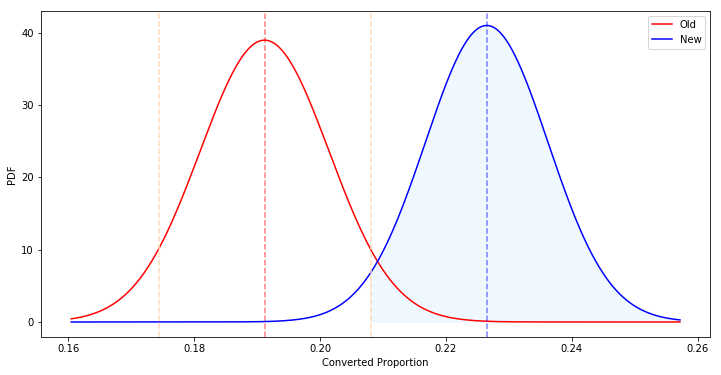

In [133]:
#Calculate 90% confidential interval for old version
a, b = proportion_confint(A_converted, N_A, alpha=0.1, method='normal')
# standard error of the mean for both groups
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(N_A)
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(N_B)
# plot the null and alternate hypothesis
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(p_A-3*SE_A, p_B+3*SE_A, N_A)
xB = np.linspace(p_A-3*SE_A, p_B+3*SE_A, N_B)
yA = scs.norm(p_A, SE_A).pdf(xA)
ax.plot(xA, yA, c='red', label="Old")
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')
yB = scs.norm(p_B, SE_B).pdf(xB)
ax.plot(xB, yB, c='blue', label="New")
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')

ax.axvline(x=a, c='peachpuff', alpha=1, linestyle='--')
ax.axvline(x=b, c='peachpuff', alpha=1, linestyle='--')

x_list = [item for item in xB if item > b]
y_list = yB[-len(x_list):]
ax.fill_between(x_list, 0, y_list, color='aliceblue')

plt.xlabel('Converted Proportion')
plt.ylabel('PDF')
plt.legend()
plt.show()

In [134]:
z_score, p_value = sm.stats.proportions_ztest(np.array([A_converted,B_converted]),np.array([N_A,N_B]), alternative = 'smaller')

In [135]:
p_value

0.006583821769771307

P<0.05 so we can be 95% confident that this result is a consequence of the changes you made and not a result of random chance.
Conversion of the new version is bigger than conversion of the old version.